In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, fusion_pf, fusion, omnipush_datasets

import matplotlib.pyplot as plt
# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind')
# plt.style.use('seaborn-poster')

In [14]:
def eval_experiment(experiment_name, omnipush=False):
    # Experiment configuration
    pf_image_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_force']),
    )

    pf_force_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['image']),
    )

    weight_model = fusion.CrossModalWeights(state_dim=0)

    pf_fusion_model = fusion_pf.ParticleFusionModel(
        pf_image_model,
        pf_force_model,
        weight_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_fusion_model,
        optimizer_names=[
            "e2e_fusion",
            "e2e_image",
            "e2e_force",
            "dynamics_image",
            "dynamics_force",
            "dynamics_recurrent_image",
            "dynamics_recurrent_force",
            "measurement_image",
            "measurement_force",
        ]
    )
    
    # Load eval data
    dataset_args = buddy.metadata
    if omnipush:
        eval_trajectories = omnipush_datasets.load_trajectories(("simpler/val.hdf5", 200), **dataset_args)
    else:
        dataset_args['start_timestep'] = 100
        eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_1000.hdf5", 100), **dataset_args)
    
    # Plotting, etc
    phases = [
#         'phase_0_dynamics_pretrain',
#         'phase_1_dynamics_pretrain_recurrent',
#         'phase_2_measurement_pretrain',
#         'phase_3_e2e_individual',
        'phase_4_e2e_joint',
#          'phase_4_e2e_joint_unfrozen',
    ]
    print(buddy.checkpoint_labels)
    for phase in phases:
        try:
            buddy.load_checkpoint(label=phase)
            pass
        except FileNotFoundError:
            print(f"Skipping {phase}")
            continue

        print(f"Evaluating {phase}")
        pf_fusion_model.image_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        pf_fusion_model.force_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        
        with torch.no_grad():
            panda_training.rollout_and_eval(
                pf_fusion_model,
                eval_trajectories,
                start_time=0,
                max_timesteps=1000,
                particle_count=200,
                noisy_dynamics=True,
                true_initial=True)


In [15]:
eval_experiment("dpf_omnipush_fusion_lr1e-5_uf", omnipush=True)

[buddy-dpf_omnipush_fusion_lr1e-5_uf] Using device: cuda
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Available checkpoint labels: ['0000000000217208', 'phase_4_e2e_joint']
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Read checkpoint from path: checkpoints/dpf_omnipush_fusion_lr1e-5_uf-0000000000217208.ckpt


RuntimeError: Error(s) in loading state_dict for ParticleFusionModel:
	size mismatch for weight_model.shared_layers.5.weight: copying a param with shape torch.Size([2, 32]) from checkpoint, the shape in current model is torch.Size([4, 32]).
	size mismatch for weight_model.shared_layers.5.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([4]).

[buddy-dpf_fusion_mujoco_blackout0_unfrozen] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0_unfrozen] Available checkpoint labels: ['0000000000205167', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_unfrozen] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_unfrozen-0000000000205167.ckpt
[buddy-dpf_fusion_mujoco_blackout0_unfrozen] Loaded checkpoint at step: 205167
['0000000000205167', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_unfrozen] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_unfrozen-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout0_unfrozen] Loaded checkpoint at step: 205167
Evaluating phase_4_e2e_joint



0.024070298906009202


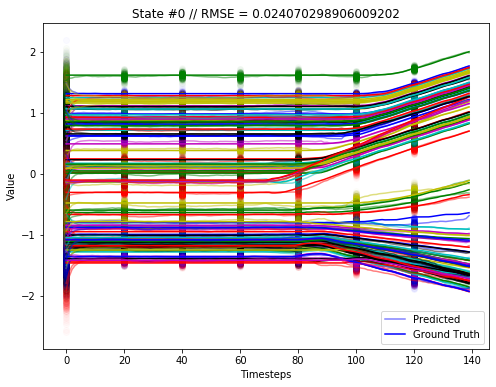

0.021247914063519606


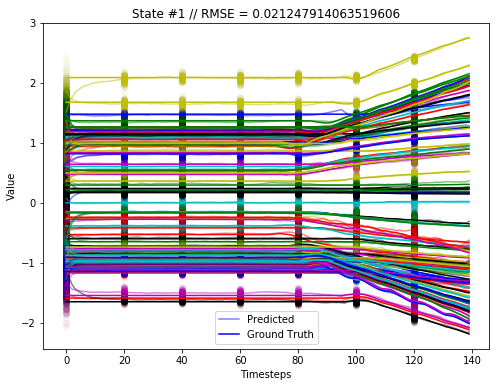

In [5]:
eval_experiment("dpf_fusion_mujoco_blackout0_unfrozen")

[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Available checkpoint labels: ['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_2x_tuned-0000000000405644.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_2x_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
Evaluating phase_4_e2e_joint



0.023196449461249893


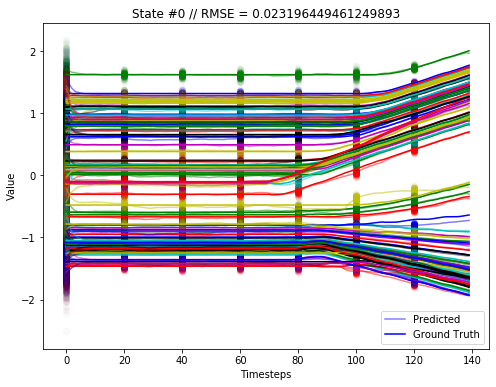

0.01887332921867839


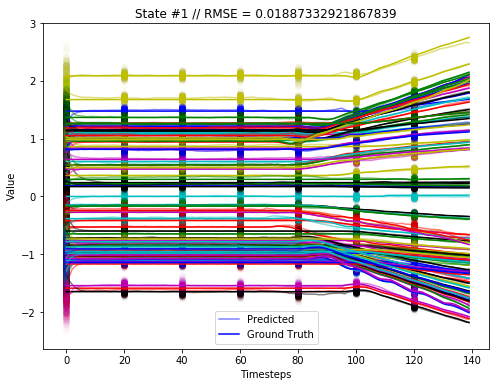

In [6]:
eval_experiment("dpf_fusion_mujoco_blackout0_2x_tuned")

[buddy-dpf_fusion_mujoco_blackout4_2x_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout4_2x_tuned] Available checkpoint labels: ['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout4_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4_2x_tuned-0000000000405644.ckpt
[buddy-dpf_fusion_mujoco_blackout4_2x_tuned] Loaded checkpoint at step: 405644
['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout4_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4_2x_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout4_2x_tuned] Loaded checkpoint at step: 405644
Evaluating phase_4_e2e_joint



0.0355630393849276


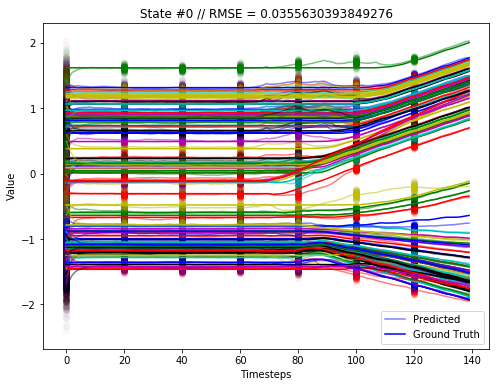

0.02748196448133118


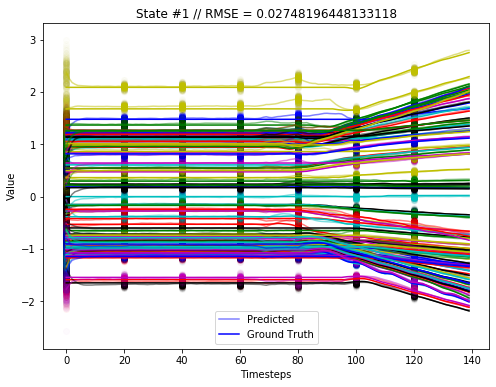

In [7]:
eval_experiment("dpf_fusion_mujoco_blackout4_2x_tuned")

[buddy-dpf_fusion_mujoco_blackout8_2x_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout8_2x_tuned] Available checkpoint labels: ['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout8_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8_2x_tuned-0000000000405644.ckpt
[buddy-dpf_fusion_mujoco_blackout8_2x_tuned] Loaded checkpoint at step: 405644
['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout8_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8_2x_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout8_2x_tuned] Loaded checkpoint at step: 405644
Evaluating phase_4_e2e_joint



0.0348947309897948


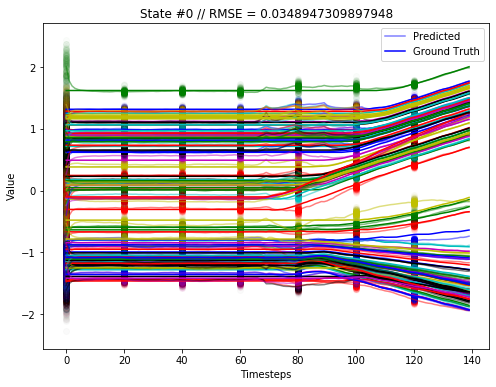

0.03715878344321635


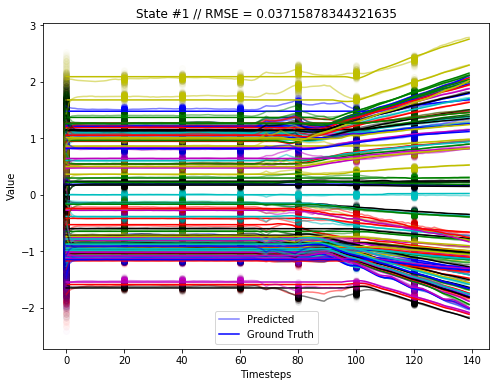

In [8]:
eval_experiment("dpf_fusion_mujoco_blackout8_2x_tuned")

[buddy-dpf_fusion_mujoco_seq5_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_seq5_tuned] Available checkpoint labels: ['0000000000205167', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_seq5_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq5_tuned-0000000000205167.ckpt
[buddy-dpf_fusion_mujoco_seq5_tuned] Loaded checkpoint at step: 205167
['0000000000205167', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_seq5_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq5_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_seq5_tuned] Loaded checkpoint at step: 205167
Evaluating phase_4_e2e_joint



0.027540416028194563


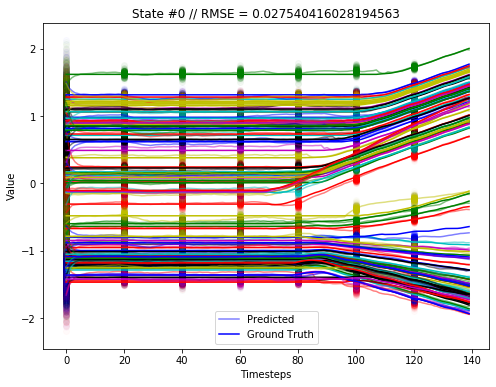

0.020546698749617336


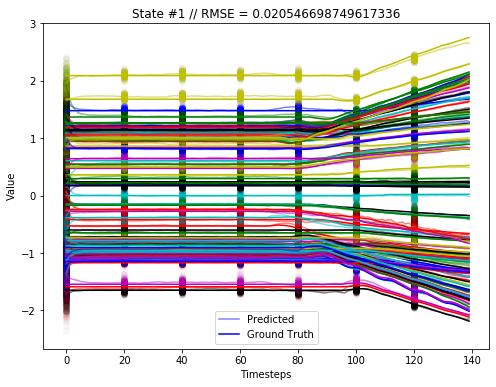

In [9]:
eval_experiment("dpf_fusion_mujoco_seq5_tuned")